In [99]:
% matplotlib inline

#importing packages
import numpy as np 
import pandas as pd 
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [3]:
# Integrating Database with notebook
database = "\\Users\\Olatunji\\Desktop\\Fall 2018\\EMSE 6992\\Final Project\\soccer\\database.sqlite"
cnx = sqlite3.connect(database)

In [4]:
#Inspecting Database
table = pd.read_sql_query("Select * from sqlite_master WHERE type = 'table'", cnx)
print(table)

    type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Te

In [44]:
player_analysis_raw = pd.read_sql("""SELECT *
                        FROM player_attributes pa JOIN
                        player p ON pa.player_api_id = p.player_api_id
                        WHERE date BETWEEN '2016-01-01 00:00:00' AND '2016-12-31 23:59:59'
                        ;""", cnx)
player_analysis_raw.head(8)

#print(player_analysis.columns)

id  player_fifa_api_id  player_api_id                 date  \
0    1              218353         505942  2016-02-18 00:00:00   
1    6              189615         155782  2016-04-21 00:00:00   
2    7              189615         155782  2016-04-07 00:00:00   
3    8              189615         155782  2016-01-07 00:00:00   
4   39              186170         162549  2016-01-07 00:00:00   
5   65              140161          30572  2016-04-21 00:00:00   
6  113              158138          27316  2016-04-28 00:00:00   
7  114              158138          27316  2016-02-25 00:00:00   

   overall_rating  potential preferred_foot attacking_work_rate  \
0            67.0       71.0          right              medium   
1            74.0       76.0           left                high   
2            74.0       76.0           left                high   
3            73.0       75.0           left                high   
4            65.0       67.0          right              medium   
5            69.0       69.0          right              medium   
6            77.0       77.0           left              medium   
7            77.0       77.0           left              medium   

  defensive_work_rate  crossing   ...    gk_kicking  gk_positioning  \
0              medium      49.0   ...          10.0             8.0   
1              medium      80.0   ...           9.0             9.0   
2              medium      80.0   ...           9.0             9.0   
3              medium      79.0   ...           9.0             9.0   
4              medium      64.0   ...          12.0             9.0   
5              medium      57.0   ...          13.0            12.0   
6              medium      77.0   ...           7.0            16.0   
7              medium      77.0   ...           7.0            16.0   

   gk_reflexes  id  player_api_id         player_name  player_fifa_api_id  \
0          8.0   1         505942  Aaron Appindangoye              218353   
1         12.0   2         155782     Aaron Cresswell              189615   
2         12.0   2         155782     Aaron Cresswell              189615   
3         12.0   2         155782     Aaron Cresswell              189615   
4         13.0   3         162549         Aaron Doran              186170   
5         11.0   4          30572       Aaron Galindo              140161   
6         15.0   6          27316          Aaron Hunt              158138   
7         15.0   6          27316          Aaron Hunt              158138   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1989-12-15 00:00:00  170.18     146  
3  1989-12-15 00:00:00  170.18     146  
4  1991-05-13 00:00:00  170.18     163  
5  1982-05-08 00:00:00  182.88     198  
6  1986-09-04 00:00:00  182.88     161  
7  1986-09-04 00:00:00  182.88     161  

[8 rows x 49 columns]

In [50]:
#unique rows of players
player_analysis = player_analysis_raw.drop_duplicates(subset = 'player_api_id')
player_analysis = player_analysis.reset_index()
player_analysis.head(3)




index  id  player_fifa_api_id  player_api_id                 date  \
0      0   1              218353         505942  2016-02-18 00:00:00   
1      1   6              189615         155782  2016-04-21 00:00:00   
2      4  39              186170         162549  2016-01-07 00:00:00   

   overall_rating  potential preferred_foot attacking_work_rate  \
0            67.0       71.0          right              medium   
1            74.0       76.0           left                high   
2            65.0       67.0          right              medium   

  defensive_work_rate   ...    gk_kicking  gk_positioning  gk_reflexes  id  \
0              medium   ...          10.0             8.0          8.0   1   
1              medium   ...           9.0             9.0         12.0   2   
2              medium   ...          12.0             9.0         13.0   3   

   player_api_id         player_name  player_fifa_api_id             birthday  \
0         505942  Aaron Appindangoye              218353  1992-02-29 00:00:00   
1         155782     Aaron Cresswell              189615  1989-12-15 00:00:00   
2         162549         Aaron Doran              186170  1991-05-13 00:00:00   

   height  weight  
0  182.88     187  
1  170.18     146  
2  170.18     163  

[3 rows x 50 columns]

In [68]:
focus_attributes = ['overall_rating','potential',  'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']


In [69]:
skill_analysis = player_analysis[focus_attributes]
print(skill_analysis.head(3))

   overall_rating  potential  crossing  finishing  heading_accuracy  \
0            67.0       71.0      49.0       44.0              71.0   
1            74.0       76.0      80.0       53.0              58.0   
2            65.0       67.0      64.0       58.0              60.0   

   short_passing  volleys  dribbling  curve  free_kick_accuracy     ...       \
0           61.0     44.0       51.0   45.0                39.0     ...        
1           71.0     40.0       73.0   70.0                69.0     ...        
2           66.0     52.0       66.0   67.0                63.0     ...        

   vision  penalties  marking  standing_tackle  sliding_tackle  gk_diving  \
0    54.0       48.0     65.0             69.0            69.0        6.0   
1    66.0       59.0     76.0             75.0            78.0       14.0   
2    68.0       61.0     23.0             22.0            24.0       16.0   

   gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0         11.0        10.0 

In [70]:
# create a list containing Pearson's correlation between 'overall_rating' with each column in cols
correlations = [ player_analysis['overall_rating'].corr(skill_analysis[f]) for f in focus_attributes ]

print(correlations)

[1.0, 0.795434628203844, 0.2990441274910182, 0.2621722792817091, 0.2416861028261093, 0.4153275908890465, 0.30802909714346033, 0.28956392641129514, 0.3248064860067559, 0.2938472470315367, 0.3916959439154251, 0.3801261580151152, 0.1667353394110999, 0.17659390110220877, 0.2042945768778716, 0.8168450467148514, 0.0890569748201759, 0.34721600610664427, 0.22177372801591025, 0.2595166353313421, 0.21692280787976229, 0.3297659678187088, 0.26067261534730196, 0.20027130045990715, 0.28159946577443873, 0.4202482086702925, 0.27442411615866036, 0.11955927133391996, 0.14600526062526692, 0.12460742087160007, 0.02063546847809349, 0.02478513489337344, 0.016162446096508628, 0.020025411173384054, 0.020282734709332683]


In [196]:
# create a function for plotting a dataframe with string columns and numeric values

def plot_dataframe(df, y_label, title):  
    color='indianred'
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    fig.set_dpi(300)
    plt.ylabel(y_label)
    plt.title(title)
    
    ax = df.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.attributes, rotation=75); #Notice the ; (remove it and see what happens !)
    plt.savefig("Features Correlation Line")
    plt.show()

In [73]:
# create a dataframe using cols and correlations

skill_correlation = pd.DataFrame({'attributes': focus_attributes, 'correlation': correlations}) 

print(skill_correlation)
#skill_correlation.to_csv('correlation', sep =',')

            attributes  correlation
0       overall_rating     1.000000
1            potential     0.795435
2             crossing     0.299044
3            finishing     0.262172
4     heading_accuracy     0.241686
5        short_passing     0.415328
6              volleys     0.308029
7            dribbling     0.289564
8                curve     0.324806
9   free_kick_accuracy     0.293847
10        long_passing     0.391696
11        ball_control     0.380126
12        acceleration     0.166735
13        sprint_speed     0.176594
14             agility     0.204295
15           reactions     0.816845
16             balance     0.089057
17          shot_power     0.347216
18             jumping     0.221774
19             stamina     0.259517
20            strength     0.216923
21          long_shots     0.329766
22          aggression     0.260673
23       interceptions     0.200271
24         positioning     0.281599
25              vision     0.420248
26           penalties     0

In [66]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Olatunji\Desktop\Fall 2018\USC SanDiegoX DSE200X\Extraneous\Week-1-Intro-new


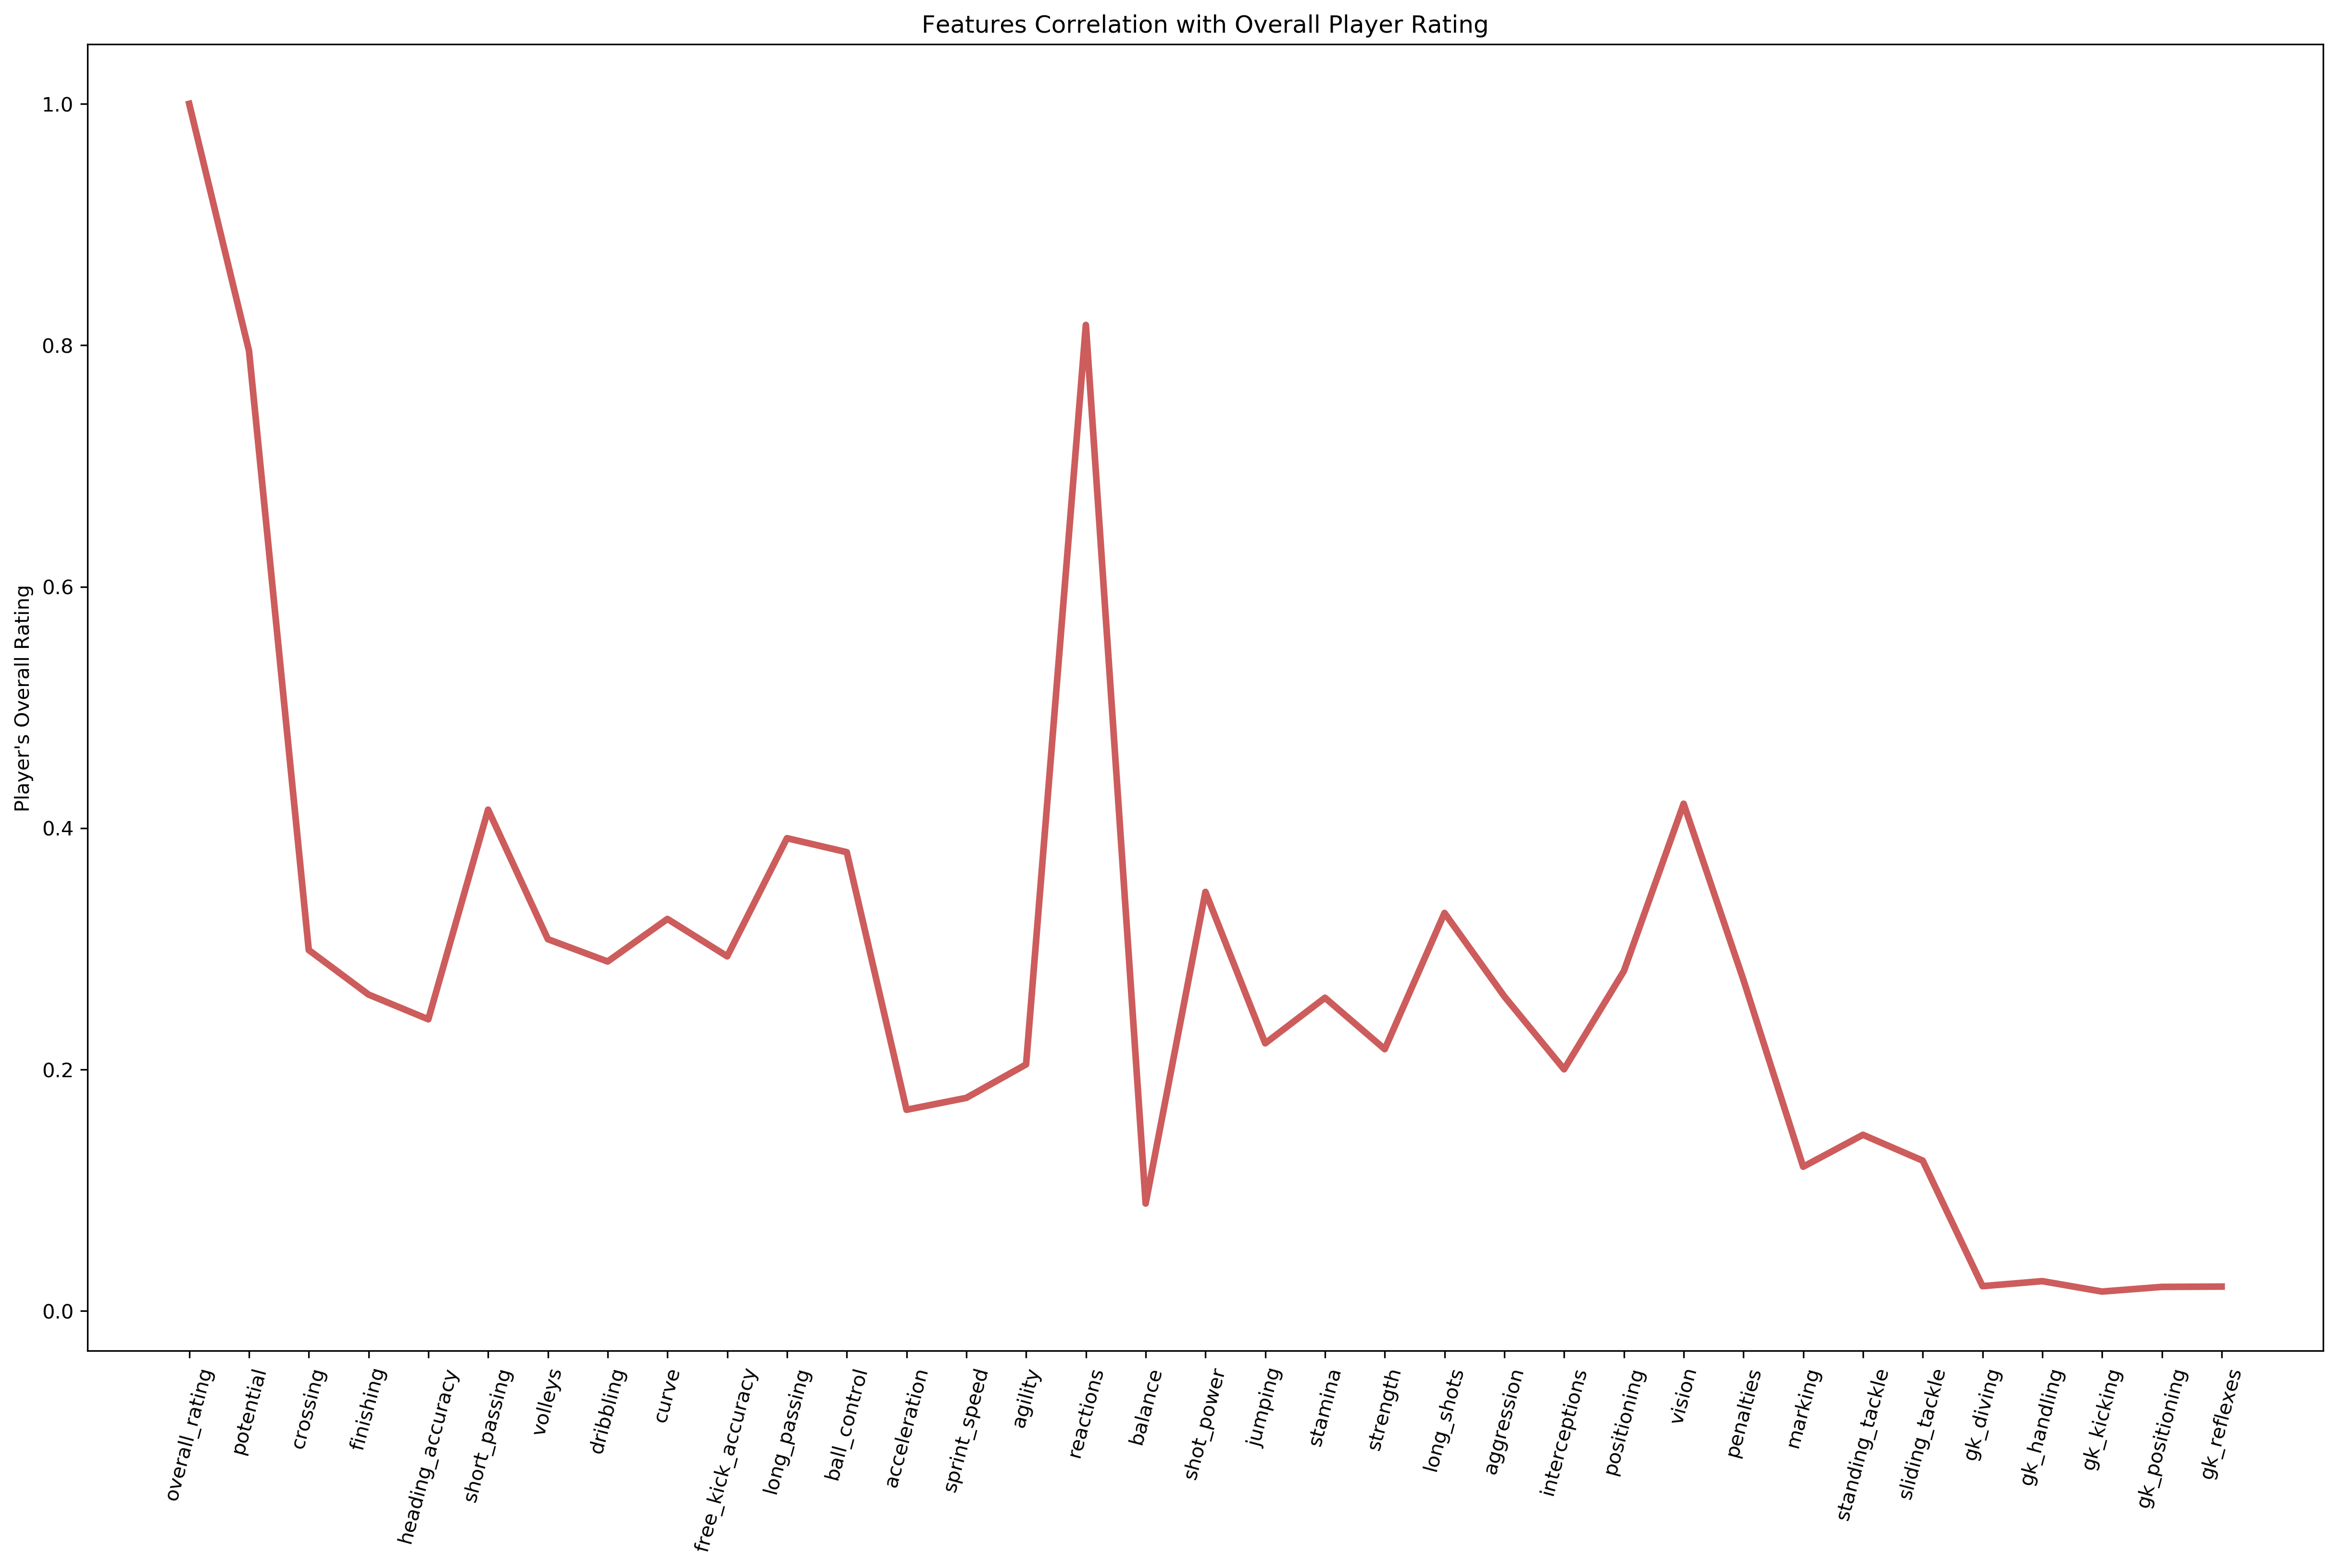

In [197]:
# Plotting df_cols_corr using the plot_dataframe function
    
plot_dataframe(skill_correlation[skill_correlation.columns.difference(['overall_rating'])], 'Player\'s Overall Rating', 'Features Correlation with Overall Player Rating')

In [ ]:
# Draw Correlation Matrix Using Seaborn

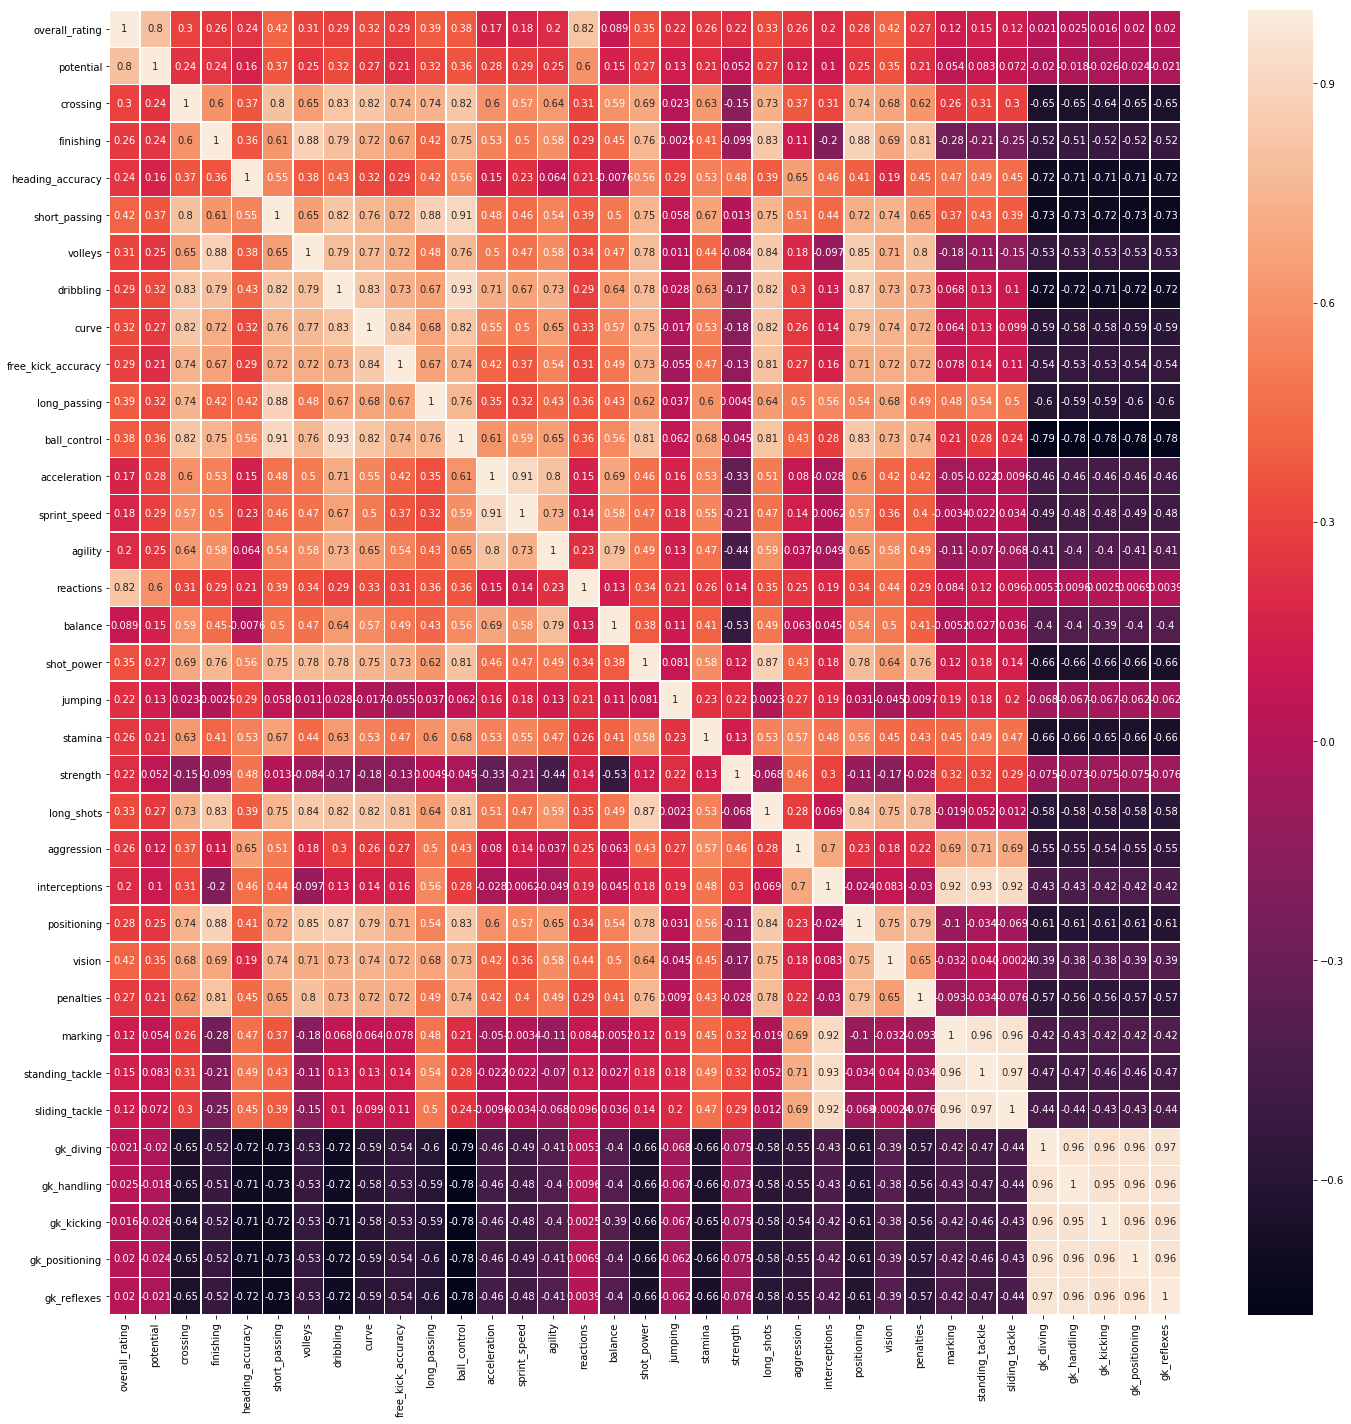

In [141]:
fig2, ax2 = plt.subplots(nrows = 1, ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(skill_analysis.corr(), annot = True, linewidths = 0.5, ax = ax2)


In [93]:
skill_correlation.sort_values(by=['correlation'], ascending= False)[:6]

attributes  correlation
0   overall_rating     1.000000
15       reactions     0.816845
1        potential     0.795435
25          vision     0.420248
5    short_passing     0.415328
10    long_passing     0.391696

## Clustering Player into Similar Groups

In [114]:
cluster_features = ['gk_kicking', 'dribbling', 'finishing', 'interceptions', 'standing_tackle', 'overall_rating']


In [115]:
# Generate a new dataframe by selecting the features

feature_cluster = player_analysis[cluster_features]



In [116]:
feature_cluster.head()

gk_kicking  dribbling  finishing  interceptions  standing_tackle  \
0        10.0       51.0       44.0           70.0             69.0   
1         9.0       73.0       53.0           67.0             75.0   
2        12.0       66.0       58.0           55.0             22.0   
3        13.0       56.0       21.0           62.0             71.0   
4         7.0       78.0       72.0           55.0             34.0   

   overall_rating  
0            67.0  
1            74.0  
2            65.0  
3            69.0  
4            77.0

In [117]:
# Perform scaling on the dataframe containing the features

data = scale(feature_cluster)

# Define number of clusters
noOfClusters = 4

# Train a model
model = KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20).fit(data)

In [118]:
print(40*'*')
print("\nCount of players in each cluster")
print(40*'*')

pd.value_counts(model.labels_, sort=False)

****************************************

Count of players in each cluster
****************************************


0    1935
1    1580
2     417
3    1654
dtype: int64

In [139]:
# Custom Plot Function for displaying Parallel Plot

def pd_centers(featuresUsed, centers):
    from itertools import cycle, islice
    from pandas.tools.plotting import parallel_coordinates
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data):
    from itertools import cycle, islice
    from pandas.tools.plotting import parallel_coordinates
    import matplotlib.pyplot as plt

    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(dpi=1200)
    plt.figure(figsize=(18,10)).gca().axes.set_ylim([-3.5,+3.5])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [123]:
# Create a composite dataframe for plotting

P = pd_centers(featuresUsed=feature_cluster, centers=model.cluster_centers_)
P

gk_kicking  dribbling  finishing  interceptions  standing_tackle  \
0   -0.277018   0.599354   0.905459      -0.911395        -0.915056   
1   -0.278056   0.393543   0.117405       0.951509         0.913156   
2    3.405761  -2.594602  -1.878923      -1.530708        -1.687278   
3   -0.268950  -0.422849  -0.697258       0.542084         0.622499   

   overall_rating  prediction  
0        0.052347           0  
1        0.715088           1  
2       -0.011019           2  
3       -0.741957           3

C:\Users\Olatunji\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.


<Figure size 7200x4800 with 0 Axes>

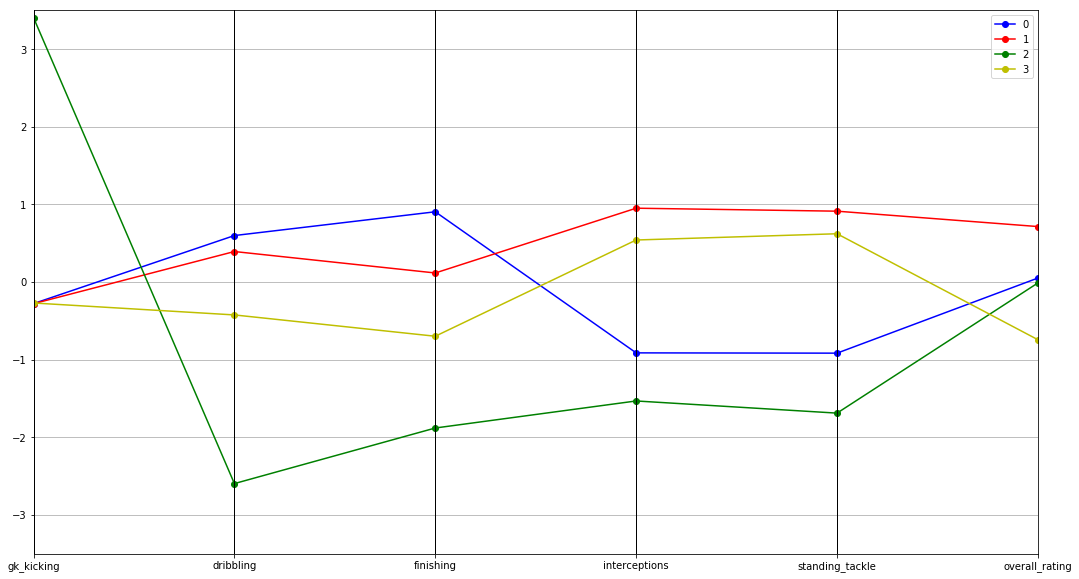

In [140]:
parallel_plot(P)

#plt.savefig('ParallelPlotCluster')

##Conclusions:

Red - Midfielders
Blue - Attacker
Gold - Defenders
Green - Goal Keepers

In [5]:
player_attr = pd.read_sql("""SELECT date, sprint_speed, p.player_api_id, player_name, birthday, height, weight
                        FROM player_attributes pa JOIN
                        player p ON pa.player_api_id = p.player_api_id
                        ;""", cnx)
player_attr.head(8)

date  sprint_speed  player_api_id         player_name  \
0  2016-02-18 00:00:00          64.0         505942  Aaron Appindangoye   
1  2015-11-19 00:00:00          64.0         505942  Aaron Appindangoye   
2  2015-09-21 00:00:00          64.0         505942  Aaron Appindangoye   
3  2015-03-20 00:00:00          64.0         505942  Aaron Appindangoye   
4  2007-02-22 00:00:00          64.0         505942  Aaron Appindangoye   
5  2016-04-21 00:00:00          78.0         155782     Aaron Cresswell   
6  2016-04-07 00:00:00          78.0         155782     Aaron Cresswell   
7  2016-01-07 00:00:00          78.0         155782     Aaron Cresswell   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1992-02-29 00:00:00  182.88     187  
2  1992-02-29 00:00:00  182.88     187  
3  1992-02-29 00:00:00  182.88     187  
4  1992-02-29 00:00:00  182.88     187  
5  1989-12-15 00:00:00  170.18     146  
6  1989-12-15 00:00:00  170.18     146  
7  1989-12-15 00:00:00  170.18     146

In [7]:
#Limiting the data fetched to 2015:
player_attr_2016 = pd.read_sql("""SELECT date, sprint_speed, p.player_api_id, player_name, birthday, height, weight
                        FROM player_attributes pa JOIN
                        player p ON pa.player_api_id = p.player_api_id
                        WHERE date BETWEEN '2016-01-01 00:00:00' AND '2016-12-31 23:59:59' ;""", cnx)
player_attr_2016.head(20)

date  sprint_speed  player_api_id         player_name  \
0   2016-02-18 00:00:00          64.0         505942  Aaron Appindangoye   
1   2016-04-21 00:00:00          78.0         155782     Aaron Cresswell   
2   2016-04-07 00:00:00          78.0         155782     Aaron Cresswell   
3   2016-01-07 00:00:00          78.0         155782     Aaron Cresswell   
4   2016-01-07 00:00:00          74.0         162549         Aaron Doran   
5   2016-04-21 00:00:00          34.0          30572       Aaron Galindo   
6   2016-04-28 00:00:00          69.0          27316          Aaron Hunt   
7   2016-02-25 00:00:00          69.0          27316          Aaron Hunt   
8   2016-04-21 00:00:00          67.0         564793          Aaron Kuhl   
9   2016-02-04 00:00:00          67.0         564793          Aaron Kuhl   
10  2016-02-25 00:00:00          26.0         528212        Aaron Lennox   
11  2016-01-28 00:00:00          26.0         528212        Aaron Lennox   
12  2016-02-04 00:00:00          71.0         231592          Aaron Mooy   
13  2016-01-21 00:00:00          71.0         231592          Aaron Mooy   
14  2016-04-28 00:00:00          78.0          40719        Aaron Niguez   
15  2016-04-14 00:00:00          78.0          40719        Aaron Niguez   
16  2016-01-21 00:00:00          78.0          40719        Aaron Niguez   
17  2016-03-10 00:00:00          69.0          75489        Aaron Ramsey   
18  2016-03-03 00:00:00          69.0          75489        Aaron Ramsey   
19  2016-02-18 00:00:00          69.0          75489        Aaron Ramsey   

               birthday  height  weight  
0   1992-02-29 00:00:00  182.88     187  
1   1989-12-15 00:00:00  170.18     146  
2   1989-12-15 00:00:00  170.18     146  
3   1989-12-15 00:00:00  170.18     146  
4   1991-05-13 00:00:00  170.18     163  
5   1982-05-08 00:00:00  182.88     198  
6   1986-09-04 00:00:00  182.88     161  
7   1986-09-04 00:00:00  182.88     161  
8   1996-01-30 00:00:00  172.72     146  
9   1996-01-30 00:00:00  172.72     146  
10  1993-02-19 00:00:00  190.50     181  
11  1993-02-19 00:00:00  190.50     181  
12  1990-09-15 00:00:00  175.26     150  
13  1990-09-15 00:00:00  175.26     150  
14  1989-04-26 00:00:00  170.18     143  
15  1989-04-26 00:00:00  170.18     143  
16  1989-04-26 00:00:00  170.18     143  
17  1990-12-26 00:00:00  177.80     154  
18  1990-12-26 00:00:00  177.80     154  
19  1990-12-26 00:00:00  177.80     154

In [9]:
#unique rows of players
unique_player_attr_2016 = player_attr_2016.drop_duplicates(subset = 'player_api_id')
unique_player_attr_2016 = unique_player_attr_2016.reset_index()
unique_player_attr_2016.head(10)

index                 date  sprint_speed  player_api_id  \
0      0  2016-02-18 00:00:00          64.0         505942   
1      1  2016-04-21 00:00:00          78.0         155782   
2      4  2016-01-07 00:00:00          74.0         162549   
3      5  2016-04-21 00:00:00          34.0          30572   
4      6  2016-04-28 00:00:00          69.0          27316   
5      8  2016-04-21 00:00:00          67.0         564793   
6     10  2016-02-25 00:00:00          26.0         528212   
7     12  2016-02-04 00:00:00          71.0         231592   
8     14  2016-04-28 00:00:00          78.0          40719   
9     17  2016-03-10 00:00:00          69.0          75489   

          player_name             birthday  height  weight  
0  Aaron Appindangoye  1992-02-29 00:00:00  182.88     187  
1     Aaron Cresswell  1989-12-15 00:00:00  170.18     146  
2         Aaron Doran  1991-05-13 00:00:00  170.18     163  
3       Aaron Galindo  1982-05-08 00:00:00  182.88     198  
4          Aaron Hunt  1986-09-04 00:00:00  182.88     161  
5          Aaron Kuhl  1996-01-30 00:00:00  172.72     146  
6        Aaron Lennox  1993-02-19 00:00:00  190.50     181  
7          Aaron Mooy  1990-09-15 00:00:00  175.26     150  
8        Aaron Niguez  1989-04-26 00:00:00  170.18     143  
9        Aaron Ramsey  1990-12-26 00:00:00  177.80     154

In [11]:
#Checking for missing data
unique_player_attr_2016.isnull().sum(axis=0)

index            0
date             0
sprint_speed     0
player_api_id    0
player_name      0
birthday         0
height           0
weight           0
dtype: int64

In [133]:
# Converting String to Datetime
birthday = unique_player_attr_2016['birthday'].astype('datetime64[ns]')
measurment_date = unique_player_attr_2016['date'].astype('datetime64[ns]')

#calculate the age.
p_age = round((measurment_date - birthday).astype('timedelta64[D]')/365.25) 



unique_player_attr_2016['age'] = p_age.astype(int)
unique_player_attr_2016.head(10)

index                 date  sprint_speed  player_api_id  \
0      0  2016-02-18 00:00:00          64.0         505942   
1      1  2016-04-21 00:00:00          78.0         155782   
2      4  2016-01-07 00:00:00          74.0         162549   
3      5  2016-04-21 00:00:00          34.0          30572   
4      6  2016-04-28 00:00:00          69.0          27316   
5      8  2016-04-21 00:00:00          67.0         564793   
6     10  2016-02-25 00:00:00          26.0         528212   
7     12  2016-02-04 00:00:00          71.0         231592   
8     14  2016-04-28 00:00:00          78.0          40719   
9     17  2016-03-10 00:00:00          69.0          75489   

          player_name             birthday  height  weight  age  
0  Aaron Appindangoye  1992-02-29 00:00:00  182.88     187   24  
1     Aaron Cresswell  1989-12-15 00:00:00  170.18     146   26  
2         Aaron Doran  1991-05-13 00:00:00  170.18     163   25  
3       Aaron Galindo  1982-05-08 00:00:00  182.88     198   34  
4          Aaron Hunt  1986-09-04 00:00:00  182.88     161   30  
5          Aaron Kuhl  1996-01-30 00:00:00  172.72     146   20  
6        Aaron Lennox  1993-02-19 00:00:00  190.50     181   23  
7          Aaron Mooy  1990-09-15 00:00:00  175.26     150   25  
8        Aaron Niguez  1989-04-26 00:00:00  170.18     143   27  
9        Aaron Ramsey  1990-12-26 00:00:00  177.80     154   25

In [17]:
print(np.sort(unique_player_attr_2016['weight'].unique()))

[126 128 130 132 134 137 139 141 143 146 148 150 152 154 157 159 161 163
 165 168 170 172 174 176 179 181 183 185 187 190 192 194 196 198 201 203
 205 207 209 212 214 216 218 220 225]


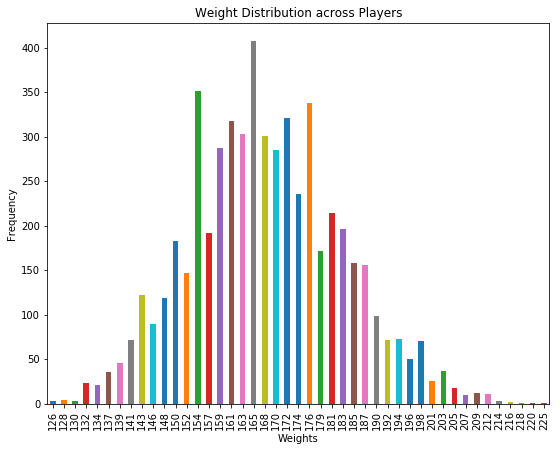

In [171]:
vc_weight = unique_player_attr_2016['weight'].value_counts().sort_index()
ax_w = vc_weight.plot(kind='bar', figsize = (9,7))
fig1 = ax_w.get_figure()
ax_w.set_xlabel("Weights")
ax_w.set_ylabel("Frequency")
ax_w.set_title("Weight Distribution across Players")

# plt.savefig('HeightDistribution')

<class 'pandas.core.series.Series'>


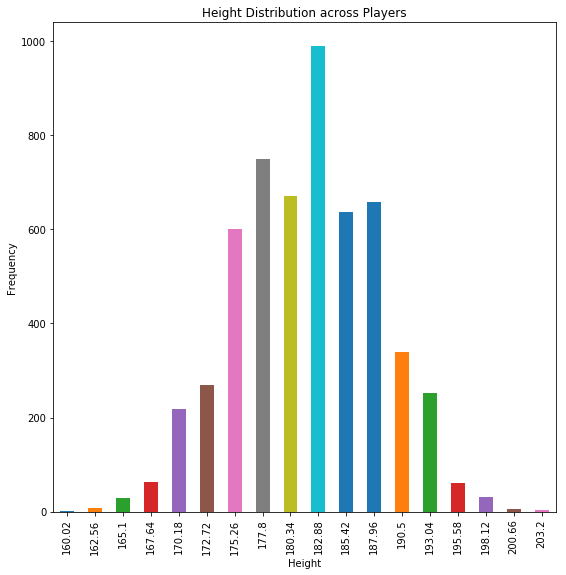

In [169]:
vc_height = unique_player_attr_2016['height'].value_counts().sort_index()
print(type(vc_height))

ax_h = vc_height.plot(kind='bar', figsize = (9,9))
fig2 = ax_h.get_figure()
ax_h.set_xlabel("Height")
ax_h.set_ylabel("Frequency")
ax_h.set_title("Height Distribution across Players")

#plt.savefig('WeightDistribution')

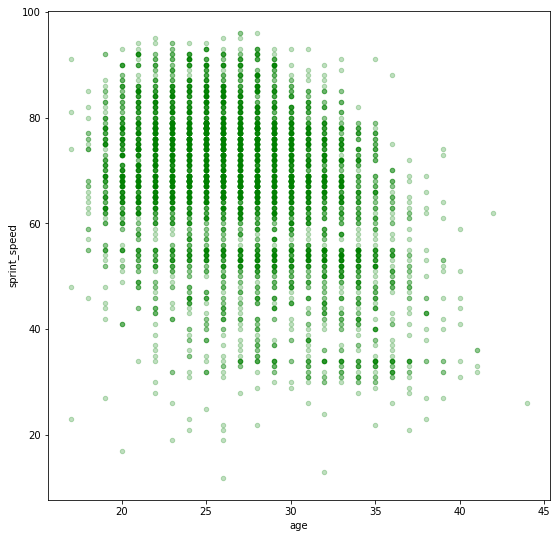

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

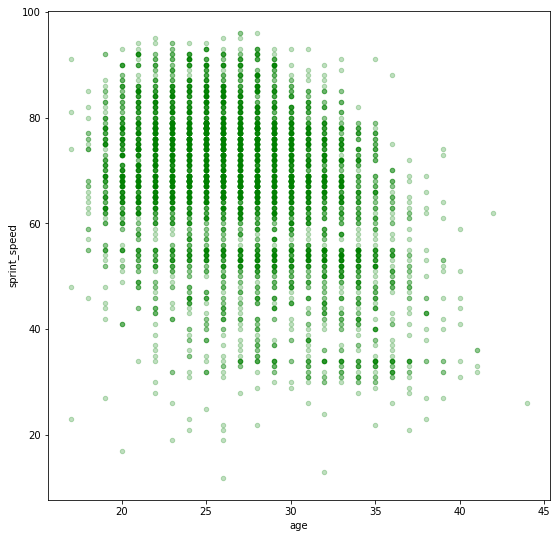

In [177]:
unique_player_attr_2016.plot(kind='scatter',x='age',y='sprint_speed', figsize=(9,9),color = 'green', alpha=0.25)
#setting the opacity here was very useful: with solid colors we wouldn't have seen where the data clusters
#plt.savefig('AgeSprint1')
plt.show(unique_player_attr_2016)


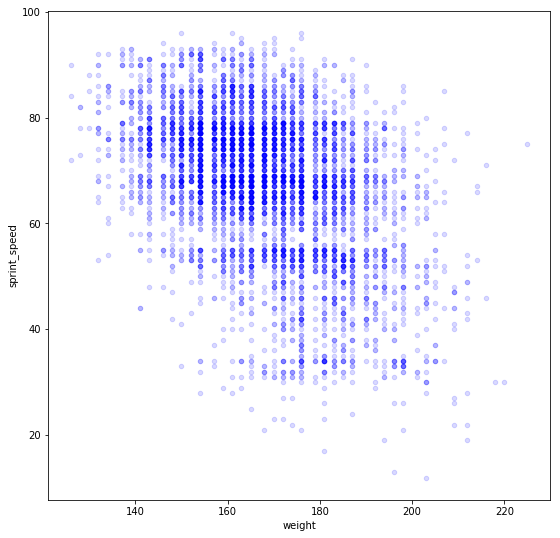

In [176]:
unique_player_attr_2016.plot(kind='scatter',x='weight',y='sprint_speed', figsize=(9,9),color = 'blue', alpha=0.15)
#plt.savefig('SprintWeight1')
plt.show()


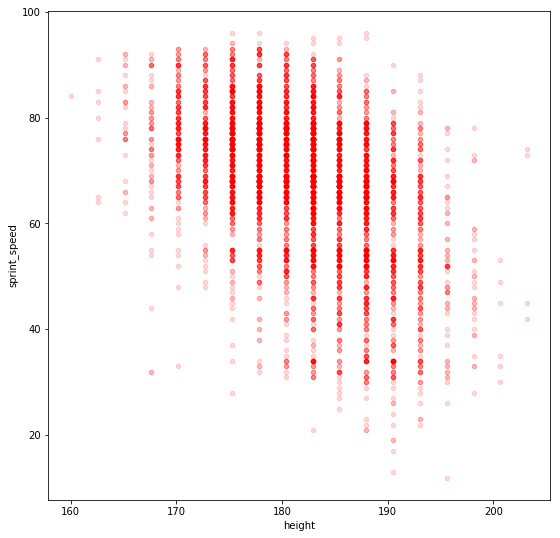

In [175]:
unique_player_attr_2016.height.astype(float)
unique_player_attr_2016.plot(kind='scatter',x='height',y='sprint_speed', figsize=(9,9),color = 'red', alpha=0.15)
#plt.savefig('SprintHeight1')
plt.show()


<h1 style="font-size:1.5em;color:#2467C0">Goal Scoring Analysis Per Game Across Different European Leagues</h1>



How did each league perform from the 2008/2009 Season through 2015/2016 Season?

In [178]:
match_league = pd.read_sql("""SELECT season, home_team_goal, away_team_goal, name, match_api_id 
                        FROM match m JOIN league l on m.league_id = l.id;""", cnx)
match_league.head()

season  home_team_goal  away_team_goal                    name  \
0  2008/2009               1               1  Belgium Jupiler League   
1  2008/2009               0               0  Belgium Jupiler League   
2  2008/2009               0               3  Belgium Jupiler League   
3  2008/2009               5               0  Belgium Jupiler League   
4  2008/2009               1               3  Belgium Jupiler League   

   match_api_id  
0        492473  
1        492474  
2        492475  
3        492476  
4        492477

In [ ]:
match_league.info()
match_league.nunique()

In [179]:
#Calculating Total Goals Scored in each match
match_league['total_goals'] = match_league['away_team_goal'] + match_league['home_team_goal']

match_league.head()

season  home_team_goal  away_team_goal                    name  \
0  2008/2009               1               1  Belgium Jupiler League   
1  2008/2009               0               0  Belgium Jupiler League   
2  2008/2009               0               3  Belgium Jupiler League   
3  2008/2009               5               0  Belgium Jupiler League   
4  2008/2009               1               3  Belgium Jupiler League   

   match_api_id  total_goals  
0        492473            2  
1        492474            0  
2        492475            3  
3        492476            5  
4        492477            4

In [ ]:
grouped_name_season = match_league.groupby(['name','season'])
 
mean_grouped = grouped_name_season['total_goals'].agg(np.mean)
mean_grouped

In [184]:
# Converting to DataFrame
league_season_goals = mean_grouped.to_frame().reset_index()
league_season_goals.head()

name     season  total_goals
0  Belgium Jupiler League  2008/2009     2.794118
1  Belgium Jupiler League  2009/2010     2.690476
2  Belgium Jupiler League  2010/2011     2.645833
3  Belgium Jupiler League  2011/2012     2.879167
4  Belgium Jupiler League  2012/2013     2.929167

In [190]:
# Check Unique league values
league_season_goals.name.unique()

array(['Belgium Jupiler League', 'England Premier League',
       'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A',
       'Netherlands Eredivisie', 'Poland Ekstraklasa',
       'Portugal Liga ZON Sagres', 'Scotland Premier League',
       'Spain LIGA BBVA', 'Switzerland Super League'], dtype=object)

In [195]:
select_league = ['Netherlands Eredivisie', 'England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga', 'Spain LIGA BBVA']
selected = league_season_goals[league_season_goals.name.isin(select_league)]

plt.figure(figsize=(13,13), dpi=1200)
ax = sns.pointplot(x='season', y='total_goals', hue='name',data=selected)
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=0.5)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.savefig('HeightDistribution')
plt.show()

Conclusions:

It is inferred from the data that player's top seepd begin a steady decline between the age range of 26 - 28 years
The ideal soccerspeed star will fall between 140 - 160 pounds


The Top rated skill sets a player will need to concentrate on are:
Reactions
Potential
Vision
Short Passing
Long Passing



The French League had the lowest scoring goal/game ratio across the years
Netherlands Eredwise League had the highest goal/game ratio from 2009/2010 season and onwards
The Spanish LIGA BBVA plateaued at 2.8 goals per game from 2010/2011 till 2012/ 2013 Season

